In [1]:
import pandas as pd
import seaborn as sns
import pybedtools as pbt
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Prepare list of genes, adding promoters
To link SNPs, peaks, and loops to genes, we first need a list of genes and their coordinates. I'll download this from GENCODE as a GTF, then extract the necessary info and convert the coordinates to BED for use in intersection with pyBedTools

In [2]:
# Change the working directory to the data dir
%cd ../data/snp_data

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data


In [3]:
%pwd

'/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data'

In [9]:
# # Download genome annotation and extract whole-gene records
# ! mkdir -p resources
# ! curl ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_33/gencode.v33.annotation.gtf.gz | \
#     gunzip -c | awk '{OFS="\t"}{if ($3 == "gene"){print $0}}' > resources/gencode.v33.annotation.gtf

In [4]:
a = pbt.BedTool("resources/gencode.v33.annotation.gtf").to_dataframe()
a.head()

,seqname,source,feature,start,end,score,strand,frame,attributes
0,chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5""; gene_type ""transc..."
1,chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5""; gene_type ""unproc..."
2,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; gene_type ""miRNA""..."
3,chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5""; gene_type ""lncRNA..."
4,chr1,ENSEMBL,gene,30366,30503,.,+,.,"gene_id ""ENSG00000284332.1""; gene_type ""miRNA""..."


In [5]:
attributes = a.attributes.str.split(';', expand=True).iloc[:,:3].apply(lambda x: x.str.split('"', expand=True)[1], axis=1)

In [6]:
attributes.columns = ['name_gene', 'gene_type', 'gene_symbol']
a = pd.concat([a.drop(columns='attributes'),attributes], axis=1)

In [7]:
# a['start'] = a['start'] - 1 # Drop to 0-based index before converting to BED
# pbt.BedTool().from_dataframe(a[['seqname', 'start', 'end', 'name_gene', 'score','strand']]).saveas('resources/gencodev33_ensembl_genes.bed')

Make a table to later convert ENSID to gene symbol

In [8]:
conversion = a[['name_gene', 'gene_symbol', 'gene_type']]
conversion.head()

,name_gene,gene_symbol,gene_type
0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene
1,ENSG00000227232.5,WASH7P,unprocessed_pseudogene
2,ENSG00000278267.1,MIR6859-1,miRNA
3,ENSG00000243485.5,MIR1302-2HG,lncRNA
4,ENSG00000284332.1,MIR1302-2,miRNA


In [9]:
genes_bed = pbt.BedTool("resources/gencodev33_ensembl_genes.bed").to_dataframe()

In [10]:
genes_bed.head()

,chrom,start,end,name,score,strand
0,chr1,11867,14409,ENSG00000223972.5,.,+
1,chr1,14402,29570,ENSG00000227232.5,.,-
2,chr1,17367,17436,ENSG00000278267.1,.,-
3,chr1,29552,31109,ENSG00000243485.5,.,+
4,chr1,30364,30503,ENSG00000284332.1,.,+


In [11]:
def addPromoter(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['start'] = 0
    else:
        x['end'] += length
    return x

In [12]:
def extractPromoters(x, length=1000):
    if x['strand'] == '+' and x['start'] > length:
        x['end'] = x['start']
        x['start'] -= length
    elif x['strand'] == '+' and x['start'] <= length:
        x['end'] = x['start']
        x['start'] = 0
    else:
        x['start'] = x['end']
        x['end'] += length
    return x

In [13]:
genes_wpromoter = genes_bed.apply(addPromoter, axis=1)

In [14]:
genes_promoters = pbt.BedTool().from_dataframe(genes_wpromoter)

In [15]:
all_promoters = genes_bed.apply(extractPromoters, axis=1)

In [16]:
all_promoters = pbt.BedTool().from_dataframe(all_promoters)

In [17]:
genes_promoters.head()

chr1	10867	14409	ENSG00000223972.5	.	+
 chr1	14402	30570	ENSG00000227232.5	.	-
 chr1	17367	18436	ENSG00000278267.1	.	-
 chr1	28552	31109	ENSG00000243485.5	.	+
 chr1	29364	30503	ENSG00000284332.1	.	+
 chr1	34552	37081	ENSG00000237613.2	.	-
 chr1	51471	53312	ENSG00000268020.3	.	+
 chr1	56596	64116	ENSG00000240361.2	.	+
 chr1	64417	71585	ENSG00000186092.6	.	+
 chr1	89293	134723	ENSG00000238009.6	.	-
 

## How many Th1/17 ATAC peaks contain a GWAS SNP?

In [18]:
# %%bash
# # Convert merged ATAC SAF file to BED
# awk 'OFS="\t" {{print $2,$3-1,$4,$1,$5}}' ../atac-seq/200102_human_th1_th17_atac/peaks/combined_peaks_merged.saf > atac_snp_loop/combined_ATAC_peaks.bed

In [19]:
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_ibd/ibd_ld_snps_r2_0.8.bed
!wc -l /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed

15486 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/ld_expansion_ibd/ibd_ld_snps_r2_0.8.bed
88138 /data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop/combined_ATAC_peaks.bed


There are 15486 unique SNPs for IBD and 88138 ATACseq peaks from Th1 and Th2



In [20]:
# Load all ATAC peaks and GWAS LD-enhanced SNPs
atac = pbt.BedTool("atac_snp_loop/combined_ATAC_peaks.bed")
gwas = pbt.BedTool("ld_expansion_ibd/ibd_ld_snps_r2_0.8.bed")

In [21]:
# Intersect ATAC peaks with GWAS SNPs
atac_gwas = atac.intersect(gwas, nonamecheck=True, loj=True).to_dataframe()
atac_gwas.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 'score', 
                     'chr_snp', 'start_snp', 'end_snp', 'name_snp']
atac_gwas = atac_gwas.replace([-1, "."], np.nan)

In [22]:
atac_gwas

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
0,chr1,9939,11526,chr1.9940.11526,NaN,NaN,NaN,NaN,NaN
1,chr1,28527,30143,chr1.28528.30143,NaN,NaN,NaN,NaN,NaN
2,chr1,38551,38855,chr1.38552.38855,NaN,NaN,NaN,NaN,NaN
3,chr1,91075,91593,chr1.91076.91593,NaN,NaN,NaN,NaN,NaN
4,chr1,127420,127976,chr1.127421.127976,NaN,NaN,NaN,NaN,NaN
5,chr1,136176,137561,chr1.136177.137561,NaN,NaN,NaN,NaN,NaN
6,chr1,180665,182081,chr1.180666.182081,NaN,NaN,NaN,NaN,NaN
7,chr1,191235,191987,chr1.191236.191987,NaN,NaN,NaN,NaN,NaN
8,chr1,199113,200559,chr1.199114.200559,NaN,NaN,NaN,NaN,NaN
9,chr1,205419,206795,chr1.205420.206795,NaN,NaN,NaN,NaN,NaN


In [23]:
pbt.BedTool().from_dataframe(atac_gwas).saveas("atac_snp_loop_ibd/ATAC_snp_overlap.bed")

<BedTool(atac_snp_loop_ibd/ATAC_snp_overlap.bed)>

In [24]:
# Find which ATAC peaks overlap promoters
atac_promoter = atac.intersect(all_promoters, nonamecheck=True).to_dataframe()

In [25]:
# How many SNPs are in each ATAC peak?
atac_gwas.groupby('name_atac').count().sort_values('name_snp', ascending=False).head()

,chrom_atac,start_atac,end_atac,score,chr_snp,start_snp,end_snp,name_snp
name_atac,,,,,,,,
chr6.32609346.32610553,41,41,41,0,41,41,41,41
chr6.32622217.32623466,30,30,30,0,30,30,30,30
chr6.32603929.32605021,28,28,28,0,28,28,28,28
chr6.32636744.32637849,20,20,20,0,20,20,20,20
chr6.32473127.32474590,19,19,19,0,19,19,19,19


In [26]:
print("%.4f%% of ATAC peaks contain a GWAS SNP" % (sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna()) / len(atac_gwas.drop_duplicates('name_atac'))))

0.0059% of ATAC peaks contain a GWAS SNP


In [27]:
atac_gwas[~atac_gwas.name_snp.isna()].drop_duplicates(["name_atac", 'name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,score,chr_snp,start_snp,end_snp,name_snp
67,chr1,1307506,1309208,chr1.1307507.1309208,NaN,chr1,1308515.0,1308516.0,rs61766198
137,chr1,2545951,2549272,chr1.2545952.2549272,NaN,chr1,2547071.0,2547072.0,rs2477678
138,chr1,2545951,2549272,chr1.2545952.2549272,NaN,chr1,2548543.0,2548544.0,rs1974044
139,chr1,2555522,2557442,chr1.2555523.2557442,NaN,chr1,2557168.0,2557169.0,rs1886730
140,chr1,2555522,2557442,chr1.2555523.2557442,NaN,chr1,2556223.0,2556224.0,rs2227312


In [28]:
# How many ATAC peaks contained GWAS SNPs?
sum(~atac_gwas.drop_duplicates('name_atac').name_snp.isna())

521

Out of the ~88k peaks, only 521 peaks contain GWAS SNPs

## Find loop-mediated ATAC-gene interactions

In [29]:
# %%bash
# # Extract the loops from BEDPE to BED files with loop IDs

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th17."NR-1"_left\nchr"$4,$5,$6,"th17."NR-1"_right"}' \
# # ../190416_human_hic/th17/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th17_anchors.bed

# # awk 'OFS="\t" {print "chr"$1,$2,$3,"th1."NR-1"_left\nchr"$4,$5,$6,"th1."NR-1"_right"}' \
# # ../190416_human_hic/th1/mega/aligned/loops_pw631/merged_loops_noheader.bedpe \
# # > all_th1_anchors.bed

# awk 'OFS="\t" {print $1,$2,$3,"loop."NR-1"_left\n"$4,$5,$6,"loop."NR-1"_right"}' \
# "loops/merged_loops.bedpe" \
# > "atac_snp_loop/all_anchors.bed"

In [30]:
# %%bash
# # Concatenate the loops from Th1 and Th17
# cat all_th17_anchors.bed all_th1_anchors.bed > all_anchors.bed

In [31]:
# Load the loops into python
# th17_anchor = pbt.BedTool("all_th17_anchors.bed")
# th1_anchor = pbt.BedTool("all_th1_anchors.bed")
all_anchor = pbt.BedTool("atac_snp_loop/all_anchors.bed")
len(all_anchor)

32488

In [32]:
def reformatAnchorName(df):
    '''Takes the anchor name, creates a new column for left vs right ("anc_pos") and 
    moves the anchor ID to the index'''
    split_anchors = df.name_anc.str.split("_", expand=True)
    split_anchors.columns = ['name_anc', 'anc_pos']
    df = df.drop(columns='name_anc')
    df = pd.concat((df, split_anchors), axis=1)
    return df

In [33]:
# Intersect all anchors with combined ATAC peaks
anchor_atac = all_anchor.intersect(atac, loj=True, nonamecheck=True).to_dataframe()
anchor_atac.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_atac", "start_atac","end_atac", "name_atac", "strand_atac"]
anchor_atac = reformatAnchorName(anchor_atac)
# Intersect all anchors with GENCODEv29 genes
anchor_gene = all_anchor.intersect(genes_promoters, loj=True, nonamecheck=True).to_dataframe()
anchor_gene.columns = ["chrom_anc", "start_anc", "end_anc", "name_anc", 
                               "chrom_gene", "start_gene","end_gene", "name_gene", "score_gene", "strand_gene"]
anchor_gene = reformatAnchorName(anchor_gene)
print("%d anchor-ATAC interactions" % len(anchor_atac))
print("%d anchor-gene interaction" % len(anchor_gene))

65696 anchor-ATAC interactions
55944 anchor-gene interaction


In [34]:
# Join the genes and atac
anchor_atac_gene = pd.merge(anchor_atac, anchor_gene, on='name_anc', suffixes=('_at','_ge'), how='left')
anchor_atac_gene.head()
# Drop useless / redundant columns
# anchor_atac_gene.drop(columns=['chrom_anc_ge', 'start_anc_ge', 'end_anc_ge','strand_atac'], inplace=True)
anchor_atac_gene.drop(columns=['strand_atac', 'score_gene'], inplace=True)
len(anchor_atac_gene)

247128

In [35]:
anchor_atac_gene = anchor_atac_gene.replace([-1, "."], np.nan)

In [36]:
anchor_atac_gene.head()

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,start_anc_ge,end_anc_ge,chrom_gene,start_gene,end_gene,name_gene,strand_gene,anc_pos_ge
0,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
1,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right
2,chr1,980000,990000,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,1060000,1070000,chr1,1058706.0,1069355.0,ENSG00000217801.10,+,right
3,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,980000,990000,chr1,975202.0,983093.0,ENSG00000187642.9,-,left
4,chr1,980000,990000,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,1060000,1070000,chr1,1062206.0,1064288.0,ENSG00000273443.1,-,right


In [37]:
# Filter for rows where the ATAC peak and gene are on opposite sides of the loop
# Also filter out rows that have no ATAC peak
loop_mediated = anchor_atac_gene[(anchor_atac_gene.anc_pos_at != anchor_atac_gene.anc_pos_ge) & (~anchor_atac_gene.name_atac.isna())]
print("Identified %d looping interactions involving ATAC peaks" % len(loop_mediated))
print("%d of these link ATAC peaks to genes" % len(loop_mediated[~loop_mediated.name_gene.isna()]))

Identified 116068 looping interactions involving ATAC peaks
109579 of these link ATAC peaks to genes


### Merge GWAS SNPs using ATAC IDs

In [38]:
# Use the ATAC peak IDs to join the GWAS SNP IDs to the data
loop_mediated_snp = pd.merge(loop_mediated, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))

In [39]:
# Remove redundant columns (everything tagged with "gw")
loop_mediated_snp = loop_mediated_snp.drop(columns=loop_mediated_snp.columns[['gw' in x for x in loop_mediated_snp.columns]])

In [40]:
# How does adding GWAS SNPs make the list longer? Answer: ATAC peaks with multiple SNPs.
print(len(loop_mediated))
print(len(loop_mediated_snp))

116068
117742


In [41]:
# How many of these interactions have SNPs?
print("There are {} loop_mediated interactions involving a SNP".format(len(loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates())))

There are 2702 loop_mediated interactions involving a SNP


In [42]:
# How many of the interactions above link to a gene?
print(len(loop_mediated_snp[(~loop_mediated_snp.name_snp.isna()) & (~loop_mediated_snp.name_gene.isna())].drop_duplicates()))

2590


In [43]:
# Export table of ATAC+SNP to gene interactions
loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].drop_duplicates().to_csv("atac_snp_loop_ibd/ATAC_snp_gene_interactions.tab", sep="\t", index=None)

## Incorporate non-looped ATAC-SNP-gene info

In [44]:
# This is a true intersection, only ATAC peaks that overlap genes+promoters are returned
atac_gene = atac.intersect(genes_promoters, wo=True, nonamecheck=True).to_dataframe()
atac_gene.head()

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts
0,chr1,9939,11526,chr1.9940.11526,.,chr1,10867,14409,ENSG00000223972.5,.,+,659
1,chr1,28527,30143,chr1.28528.30143,.,chr1,28552,31109,ENSG00000243485.5,.,+,1591
2,chr1,28527,30143,chr1.28528.30143,.,chr1,29364,30503,ENSG00000284332.1,.,+,779
3,chr1,28527,30143,chr1.28528.30143,.,chr1,14402,30570,ENSG00000227232.5,.,-,1616
4,chr1,91075,91593,chr1.91076.91593,.,chr1,89549,92105,ENSG00000239945.1,.,-,518


In [45]:
# Reformat dataframe
atac_gene.drop(columns=['score', 'blockStarts'], inplace=True)
atac_gene.columns = ['chrom_atac', 'start_atac', 'end_atac', 'name_atac', 
                     'chrom_gene', 'start_gene', 'end_gene', 'name_gene', 'score_gene', 'strand_gene']

In [46]:
# Merge atac-gwas overlaps using the atac ID
atac_gene_gwas = pd.merge(atac_gene, atac_gwas, on='name_atac', how='left', suffixes=('', '_gw'))
# Remove redudnant columns
atac_gene_gwas = atac_gene_gwas.drop(columns=atac_gene_gwas.columns[['gw' in x for x in atac_gene_gwas.columns]])
# Save as table
# atac_gene_gwas.to_csv("atac_snp_loop_ibd/atac_gene_gwas_direct.tab", sep="\t", index=None)

In [47]:
atac_gene_gwas.dropna(subset=['name_snp']).head()

,chrom_atac,start_atac,end_atac,name_atac,chrom_gene,start_gene,end_gene,name_gene,score_gene,strand_gene,score,chr_snp,start_snp,end_snp,name_snp
81,chr1,1307506,1309208,chr1.1307507.1309208,chr1,1292388,1310609,ENSG00000131584.19,.,-,NaN,chr1,1308515.0,1308516.0,rs61766198
82,chr1,1307506,1309208,chr1.1307507.1309208,chr1,1307595,1311677,ENSG00000169972.12,.,+,NaN,chr1,1308515.0,1308516.0,rs61766198
166,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2529062,2547460,ENSG00000272449.2,.,+,NaN,chr1,2547071.0,2547072.0,rs2477678
167,chr1,2545951,2549272,chr1.2545952.2549272,chr1,2529062,2547460,ENSG00000272449.2,.,+,NaN,chr1,2548543.0,2548544.0,rs1974044
168,chr1,2555522,2557442,chr1.2555523.2557442,chr1,2549918,2558031,ENSG00000238164.6,.,-,NaN,chr1,2557168.0,2557169.0,rs1886730


In [48]:
all_interactions = pd.concat([loop_mediated_snp, atac_gene_gwas], sort=False)

In [49]:
all_interactions = all_interactions.replace([-1,'.'], np.nan).drop_duplicates()
all_interactions.shape

(200511, 24)

In [50]:
# Add gene names using ensembl IDs
all_interactions = pd.merge(all_interactions, conversion, on='name_gene', how="left")
all_interactions.shape

(200511, 26)

In [51]:
all_interactions.gene_symbol.sort_values()

157421           A1BG
157422       A1BG-AS1
133807        A2M-AS1
133791          A2ML1
22903           A2ML1
133790      A2ML1-AS1
133788      A2ML1-AS1
133814          A2MP1
133810          A2MP1
168760         A4GALT
135055           AAAS
135056           AAAS
137343           AACS
137342           AACS
80170           AADAC
80166           AADAC
80172           AADAC
80295           AADAC
80168           AADAC
80297           AADAC
173305    AADACL2-AS1
80171     AADACL2-AS1
173309    AADACL2-AS1
80167     AADACL2-AS1
173308    AADACL2-AS1
80173     AADACL2-AS1
80169     AADACL2-AS1
173310    AADACL2-AS1
173311    AADACL2-AS1
173307    AADACL2-AS1
             ...     
117075            NaN
117076            NaN
117077            NaN
117078            NaN
117079            NaN
117081            NaN
117082            NaN
117087            NaN
117140            NaN
117143            NaN
117145            NaN
117261            NaN
117262            NaN
117263            NaN
117291    

In [52]:
all_interactions['atac_promoter'] = all_interactions.name_atac.isin(atac_promoter.name)

In [53]:
# Drop any row that doesn't link to a gene
# all_interactions = all_interactions.dropna(subset=['name_gene'])

In [54]:
all_interactions.shape

(200511, 27)

In [55]:
genes_snp_in_promoter = set(all_interactions[(all_interactions.atac_promoter) & (~all_interactions.name_snp.isna())].gene_symbol.dropna())

## Useful stats

In [56]:
print("%d loop-mediated interactions" % len(all_interactions[~all_interactions.anc_pos_at.isin([np.nan])]))
print("%d direct interaction" % len(all_interactions[all_interactions.anc_pos_at.isin([np.nan])]))
print("%d total interactions" % len(all_interactions))

117742 loop-mediated interactions
82769 direct interaction
200511 total interactions


In [57]:
# Involving a SNP?
print("%d SNPs participate in loop-mediated interactions" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d loop-mediated interactions with SNPs" % 
      len(all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d SNPs participate in direct interactions" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()))
print("%d direct interaction with SNPs" % 
      len(all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())]))
print("%d total interactions" % 
      len(all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(['name_atac', 'name_snp'])))

538 SNPs participate in loop-mediated interactions
2702 loop-mediated interactions with SNPs
837 SNPs participate in direct interactions
1063 direct interaction with SNPs
1015 total interactions


In [58]:
# How many of the unique SNPs from loop-mediated vs direct interactions are overlapping? 
# I.e. what is the intersection of the two sets of SNP IDs?
loop_uniq_snpid = all_interactions[(~all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
direct_uniq_snpid = all_interactions[(all_interactions.anc_pos_at.isna()) & (~all_interactions.name_snp.isna())].name_snp.unique()
print("%d SNPs have looped and/or direct interactions" % len(np.union1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have both looped and direct interactions" % len(np.intersect1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY looped interactions" % len(np.setdiff1d(loop_uniq_snpid, direct_uniq_snpid)))
print("%d SNPs have ONLY direct interactions" % len(np.setdiff1d(direct_uniq_snpid, loop_uniq_snpid)))

1015 SNPs have looped and/or direct interactions
360 SNPs have both looped and direct interactions
178 SNPs have ONLY looped interactions
477 SNPs have ONLY direct interactions


In [59]:
genes_direct = atac_gene_gwas[~atac_gene_gwas.name_snp.isna()].name_gene.dropna().unique()
genes_indirect = loop_mediated_snp[~loop_mediated_snp.name_snp.isna()].name_gene.dropna().unique()

In [60]:
# Annotate lead SNPs
# lead_snps = pd.read_table("../GWAS_snps/query_gwas_snps_hg38.bed", header=None)
lead_snps = pd.read_table("ld_expansion_ibd/ld_snps_info.tab")
all_interactions['is_lead_snp'] = all_interactions.name_snp.isin(lead_snps['query'])
all_interactions[all_interactions.is_lead_snp]
# Add column indicating whether interaction is looped or not
all_interactions['is_looped'] = ~all_interactions.name_anc.isna()

In [61]:
print("A total of {} lead SNPs were used from the EBI GWAS catalog".format(lead_snps.drop_duplicates('query').shape[0]))
print("These SNPs were used to query the LD data from the 1000 Genomes project, \
resulting in a total of {} SNPs identified within R2>=0.8 of a GWAS lead SNP".format(lead_snps.drop_duplicates('result').shape[0]))

A total of 635 lead SNPs were used from the EBI GWAS catalog
These SNPs were used to query the LD data from the 1000 Genomes project, resulting in a total of 15486 SNPs identified within R2>=0.8 of a GWAS lead SNP


In [62]:
print("Among the SNP catalog identified, {} overlapped a Th-cell ATAC peak (Th1 or Th17).".format(len(all_interactions.name_snp.dropna().unique())))

Among the SNP catalog identified, 1015 overlapped a Th-cell ATAC peak (Th1 or Th17).


In [63]:
print("We identified {} looped interactions involving an ATAC peak, SNP, and gene.".format(sum(all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("We also identified {} non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.".format(sum(~all_interactions[(~all_interactions.name_snp.isna()) & (~all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_gene', 'name_snp']).is_looped)))
print("{} SNPs associated with ATAC and/or loop but did not associate with a gene".format(len(all_interactions[(~all_interactions.name_snp.isna()) & (all_interactions.name_gene.isna())].drop_duplicates(['name_atac', 'name_snp']))))

We identified 2504 looped interactions involving an ATAC peak, SNP, and gene.
We also identified 1007 non-looped interactions involving a SNP within an ATAC peak located within a gene or promoter.
107 SNPs associated with ATAC and/or loop but did not associate with a gene


In [64]:
looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For looped interactions, there were {} unique genes associated with SNPs".format(len(looped_genes)))
non_looped_genes = set(all_interactions.loc[(~all_interactions.name_snp.isna()) & (~all_interactions.is_looped) & (~all_interactions.name_gene.isna()),'gene_symbol'])
print("For non-looped interactions, there were {} unique genes associated with SNPs".format(len(non_looped_genes)))
print("There were {} genes shared betweent these".format(len(looped_genes.intersection(non_looped_genes))))

For looped interactions, there were 581 unique genes associated with SNPs
For non-looped interactions, there were 338 unique genes associated with SNPs
There were 51 genes shared betweent these


In [67]:
our_genes = set(all_interactions[~all_interactions.name_snp.isna()].gene_symbol.dropna().unique())
len(our_genes)

868

## How does our method compare to previous studies associating MS risk genes with SNPs?

In [68]:
from matplotlib_venn import venn3, venn2

In [69]:
all_interactions.columns

Index(['chrom_anc_at', 'start_anc_at', 'end_anc_at', 'chrom_atac',
       'start_atac', 'end_atac', 'name_atac', 'name_anc', 'anc_pos_at',
       'chrom_anc_ge', 'start_anc_ge', 'end_anc_ge', 'chrom_gene',
       'start_gene', 'end_gene', 'name_gene', 'strand_gene', 'anc_pos_ge',
       'score', 'chr_snp', 'start_snp', 'end_snp', 'name_snp', 'score_gene',
       'gene_symbol', 'gene_type', 'atac_promoter', 'is_lead_snp',
       'is_looped'],
      dtype='object')

In [70]:
atac_only = set(all_interactions[~all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
looped = set(all_interactions[all_interactions.is_looped].dropna(subset=["name_snp"]).gene_symbol)
promoter = set(all_interactions[all_interactions.atac_promoter].dropna(subset=["name_snp"]).gene_symbol)

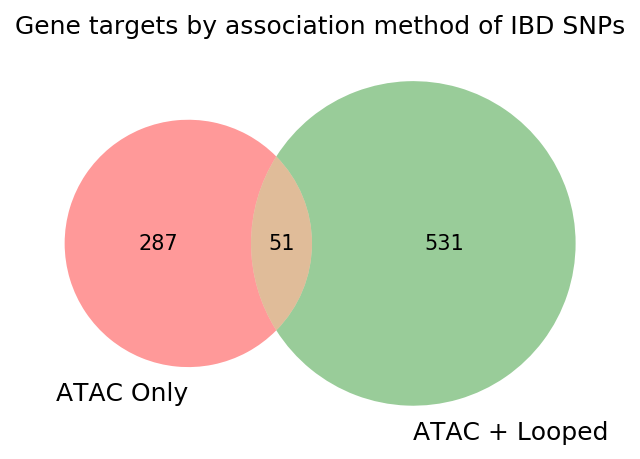

In [71]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=150)
venn2((atac_only, looped), set_labels=("ATAC Only", "ATAC + Looped"))
plt.title("Gene targets by association method of IBD SNPs")
plt.show()

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


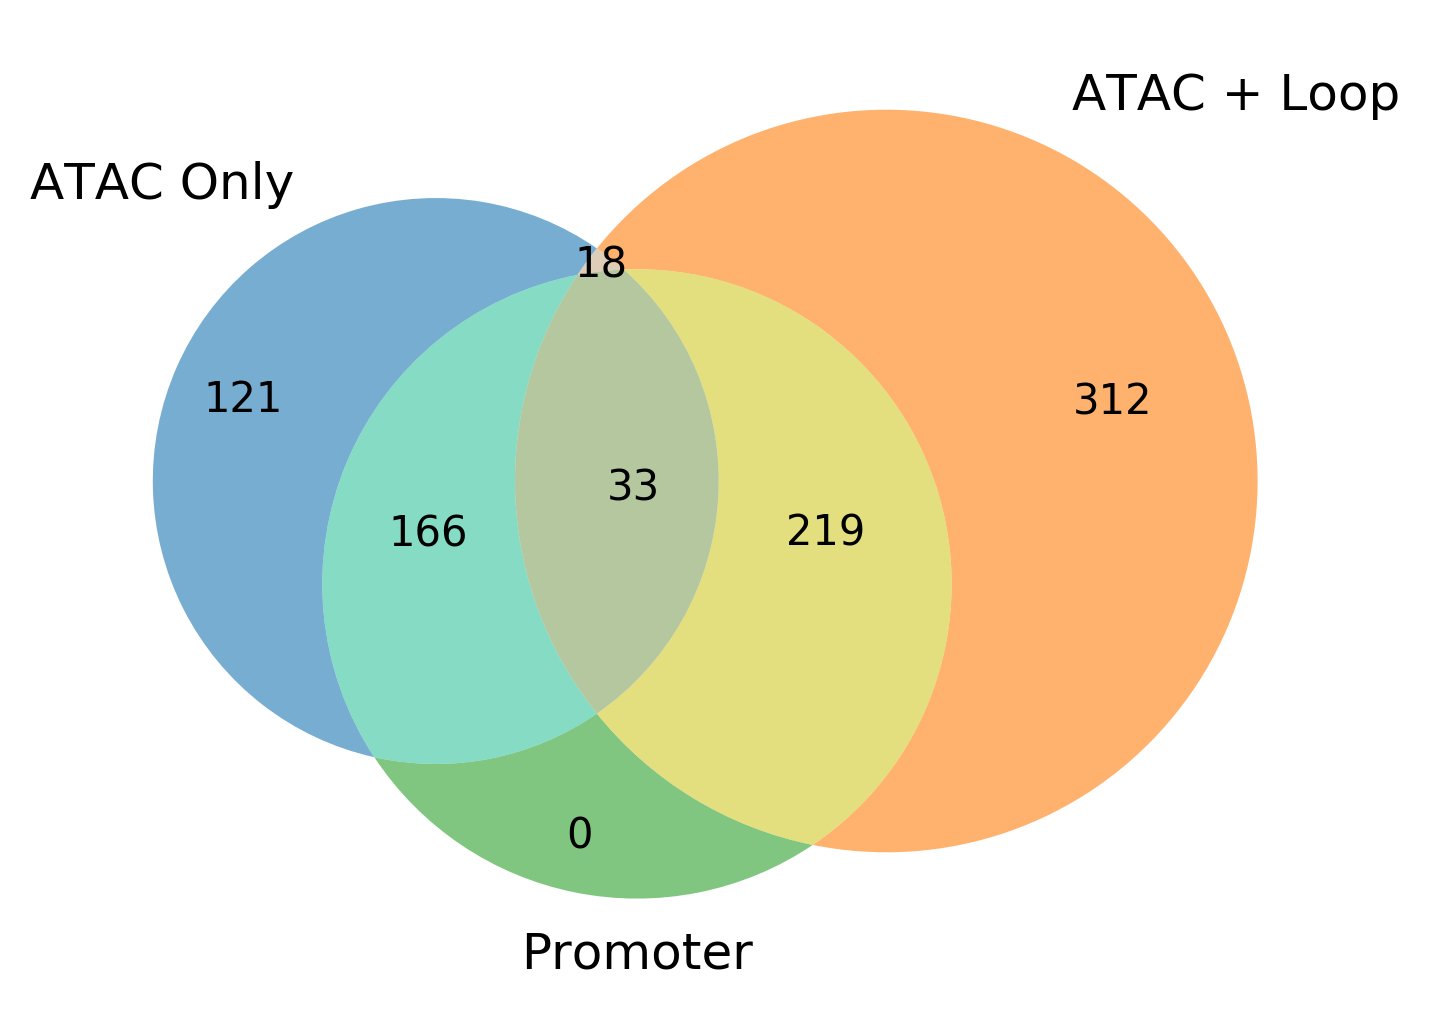

In [72]:
f, ax = plt.subplots(1,1,figsize=(5,5), dpi=300)
venn3((atac_only, #Remove all the weird genes (pseudogenes or other)
       looped,
      promoter),
     set_labels=("ATAC Only", "ATAC + Loop", "Promoter"), 
      set_colors=sns.palettes.color_palette()[:3], alpha=0.6, ax=ax)
# ax.set_title("Genes Targeted by >= 1 SNP", pad=20, size=20)
f.tight_layout()

Ok , so incorporating looping identifies novel target genes. Which are they? Do we have some examples of obvious importance?

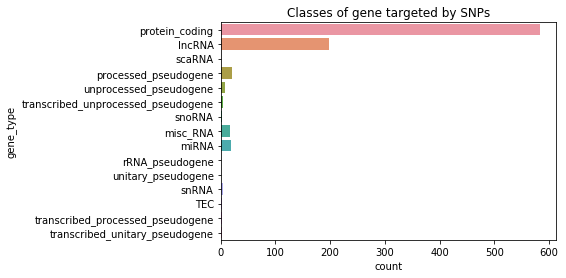

In [73]:
sns.countplot(data=all_interactions[~all_interactions.name_snp.isna()].drop_duplicates(["name_gene"]), y="gene_type")
plt.title("Classes of gene targeted by SNPs")
plt.show()

# Load RPKM data

In [75]:
%cd /gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new//data/rna-seq

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq


In [76]:
!pwd

/gpfs/fs1/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq


In [77]:
th_rpkm = pd.read_table("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/rna-seq/190311_human_th_rnaseq/rpkm_bygroup.tab")
th_rpkm.drop(columns=['Geneid', 'Length'], inplace=True)
th_rpkm = th_rpkm.dropna(subset=["gene_symbol"])

/data/reddylab/software/miniconda3/envs/revathy_py3/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


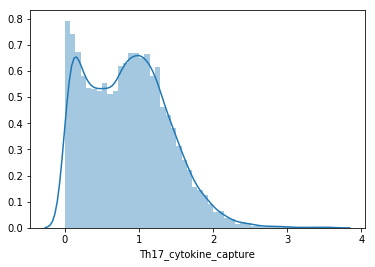

In [78]:
sns.distplot(np.log10(th_rpkm.Th17_cytokine_capture+1))

In [80]:
all_interactions_rpkm = pd.merge(all_interactions, th_rpkm, on='gene_symbol', how='left')
all_interactions_rpkm.to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop_ibd/all_interactions_rpkm.tab", sep="\t", index=False)
all_interactions_rpkm

,chrom_anc_at,start_anc_at,end_anc_at,chrom_atac,start_atac,end_atac,name_atac,name_anc,anc_pos_at,chrom_anc_ge,...,gene_symbol,gene_type,atac_promoter,is_lead_snp,is_looped,description,Th1_cytokine_capture,Th1_standard,Th17_cytokine_capture,Th17_standard
0,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
1,chr1,980000.0,990000.0,chr1,981176.0,981979.0,chr1.981177.981979,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
2,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL645608.8,lncRNA,False,False,True,NaN,NaN,NaN,NaN,NaN
3,chr1,980000.0,990000.0,chr1,984028.0,984645.0,chr1.984029.984645,loop.0,left,chr1,...,AL390719.1,transcribed_unprocessed_pseudogene,False,False,True,NaN,1.070383,3.702225,1.389806,2.604054
4,chr1,1060000.0,1070000.0,chr1,1058908.0,1060229.0,chr1.1058909.1060229,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
5,chr1,1060000.0,1070000.0,chr1,1063617.0,1064845.0,chr1.1063618.1064845,loop.0,right,chr1,...,PERM1,protein_coding,True,False,True,NaN,NaN,NaN,NaN,NaN
6,chr1,1060000.0,1070000.0,chr1,1068561.0,1070150.0,chr1.1068562.1070150,loop.0,right,chr1,...,PERM1,protein_coding,False,False,True,NaN,NaN,NaN,NaN,NaN
7,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.1,left,chr1,...,TNFRSF18,protein_coding,False,False,True,TNF receptor superfamily member 18 [Source:HGN...,36.415398,9.411021,43.451214,9.871080
8,chr1,1205000.0,1210000.0,chr1,1207942.0,1209199.0,chr1.1207943.1209199,loop.1,right,chr1,...,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN
9,chr1,1120000.0,1125000.0,chr1,1121668.0,1122974.0,chr1.1121669.1122974,loop.2,left,chr1,...,B3GALT6,protein_coding,False,False,True,"beta-1,3-galactosyltransferase 6 [Source:HGNC ...",9.910156,7.159846,7.532108,6.526830


In [81]:
all_interactions_rpkm.dropna(subset=['name_snp']).to_csv("/data/reddylab/Revathy/collabs/Maria/human-th-ms_new/data/snp_data/atac_snp_loop_ibd/all_interactions_with_snp.tab", sep="\t", index=False)

## Pivoting by genes or SNPs

In [104]:
filtered_linkage = pd.read_table("atac_snp_loop_ibd/all_interactions_with_snp.tab")

In [105]:
filtered_linkage.shape

(3765, 34)

In [107]:
snp_info = pd.read_csv("ld_expansion_ibd/ld_snps_info.tab", 
                       sep="\t").drop(columns=['synonyms', 'chrom', 'start', 'end'])

In [108]:
snp_info_cols = snp_info.columns.tolist()

In [109]:
snp_info_cols

['query',
 'result',
 'r2',
 'd_prime',
 'snp_id',
 'MAF',
 'minor_allele',
 'consequence',
 'allele_string']

In [110]:
snp_info_cols[0] = "lead_snp"
snp_info.columns = snp_info_cols

In [111]:
snp_info.drop_duplicates(subset=['lead_snp', 'result'])

,lead_snp,result,r2,d_prime,snp_id,MAF,minor_allele,consequence,allele_string
0,rs6740462,rs268124,0.980167,0.994978,rs268124,0.30970,C,intron_variant,C/G/T
1,rs12942547,rs8071537,0.800839,0.999999,rs8071537,0.38000,T,intron_variant,G/T
2,rs12942547,rs8073517,0.810302,0.995154,rs8073517,0.48720,T,intron_variant,T/A/C
3,rs12942547,rs35840966,0.814715,0.999999,rs35840966,0.39200,T,intron_variant,C/T
4,rs12942547,rs12949918,0.979611,0.995859,rs12949918,0.39780,C,intron_variant,T/C
5,rs12942547,rs8073836,1.000000,1.000000,rs8073836,0.49080,C,intron_variant,C/T
6,rs12942547,rs957971,0.814715,0.999999,rs957971,0.48960,G,intron_variant,C/G
7,rs12942547,rs8070763,0.800839,0.999999,rs8070763,0.38000,C,intron_variant,T/C
8,rs12942547,rs957970,0.814715,0.999999,rs957970,0.39200,G,intron_variant,A/G
9,rs12942547,rs12942611,0.800839,0.999999,rs12942611,0.38000,A,intron_variant,C/A


In [112]:
filter_w_info = filtered_linkage.merge(snp_info, 
                                       left_on="name_snp", 
                                       right_on="result").drop(columns=['result', 'snp_id', 'score_gene', 'score'])

In [113]:
filter_w_info.to_csv("atac_snp_loop_ibd/all_interactions_with_snp_info.tab", sep="\t", index=None)

In [114]:
# Get sorted list of genes with largest number of SNPs, removing duplicate gene-snp records
sorted_gene_by_n_snp = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_gene').size().sort_values(ascending=False)

In [115]:
filtered_linkage['th1_max_rpkm'] = filtered_linkage.loc[:,['Th1_cytokine_capture', 'Th1_standard']].max(axis=1)
filtered_linkage['th17_max_rpkm'] = filtered_linkage.loc[:,['Th17_cytokine_capture', 'Th17_standard']].max(axis=1)

In [116]:
# Produce a pivot table sorted by number of SNPs per gene
linkage_pivot_genes = filtered_linkage.pivot_table(index=['name_gene'], aggfunc={'name_snp' : lambda x: ';'.join(x),
                                                                                         'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max})
linkage_pivot_genes = linkage_pivot_genes.iloc[linkage_pivot_genes.index.get_level_values(level=0).reindex(sorted_gene_by_n_snp.index)[1]]

In [117]:
linkage_pivot_genes['n_snps'] = linkage_pivot_genes['name_snp'].str.split(';').apply(lambda x: len(np.unique(x)))

In [118]:
linkage_pivot_genes.head()

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000276410.3,H2BC3,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000227507.2,LTB,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,1052.732148,264.943496,99
ENSG00000232810.4,TNF,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,62.315754,44.043060,99
ENSG00000234816.2,H2AC5P,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000286522.1,H3C2,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99


In [119]:
sorted_gene_by_n_snp

name_gene
ENSG00000276410.3     99
ENSG00000227507.2     99
ENSG00000232810.4     99
ENSG00000234816.2     99
ENSG00000286522.1     99
ENSG00000287080.1     99
ENSG00000278705.1     99
ENSG00000204475.10    99
ENSG00000278463.1     99
ENSG00000204482.10    99
ENSG00000196735.13    35
ENSG00000071242.12    26
ENSG00000196301.3     21
ENSG00000227598.1     19
ENSG00000115896.16    19
ENSG00000237693.4     19
ENSG00000272980.4     17
ENSG00000213066.13    17
ENSG00000198502.6     15
ENSG00000184939.16    15
ENSG00000168802.13    15
ENSG00000141076.18    15
ENSG00000039068.19    15
ENSG00000196126.11    15
ENSG00000103044.11    15
ENSG00000286140.1     15
ENSG00000103047.8     15
ENSG00000179344.16    14
ENSG00000082074.18    13
ENSG00000109320.13    13
                      ..
ENSG00000154814.14     1
ENSG00000221303.1      1
ENSG00000156599.11     1
ENSG00000156603.18     1
ENSG00000156650.14     1
ENSG00000156675.16     1
ENSG00000225914.3      1
ENSG00000226032.2      1
ENSG00000227198

In [122]:
linkage_pivot_genes.to_excel("atac_snp_loop_ibd/linkage_pivot_genes.xlsx")

In [123]:
sorted_snp_by_n_gene = filtered_linkage.drop_duplicates(['name_gene', 'name_snp']).groupby('name_snp').size().sort_values(ascending=False)
linkage_pivot_snps = filtered_linkage.pivot_table(index=['name_snp', 'name_gene'], aggfunc={'gene_symbol' : lambda x: np.unique(x),
                                                                                       'th1_max_rpkm' : max,
                                                                                       'th17_max_rpkm' : max,
                                                                                           'is_looped' : np.mean})
linkage_pivot_snps = linkage_pivot_snps.iloc[linkage_pivot_snps.index.get_level_values(level=0).reindex(sorted_snp_by_n_gene.index)[1]]

In [125]:
linkage_pivot_snps.to_excel('atac_snp_loop_ibd/linkage_pivot_snps.xlsx')

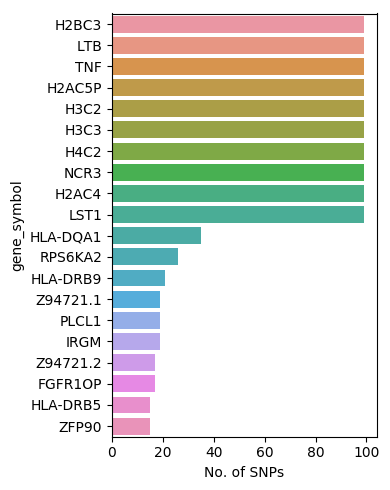

In [126]:
f, ax = plt.subplots(1,1,figsize=(4,5), dpi=100)
sns.barplot(data=linkage_pivot_genes[:20], y='gene_symbol', x="n_snps", ax=ax)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("No. of SNPs")
f.tight_layout()

In [127]:
filtered_nodup = filtered_linkage[['name_gene', 'name_snp', 'is_looped', 'is_lead_snp', 'gene_symbol']].drop_duplicates()

In [128]:
linkage_pivot_genes.head(20)

,gene_symbol,name_snp,th17_max_rpkm,th1_max_rpkm,n_snps
name_gene,,,,,
ENSG00000276410.3,H2BC3,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000227507.2,LTB,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,1052.732148,264.943496,99
ENSG00000232810.4,TNF,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,62.315754,44.043060,99
ENSG00000234816.2,H2AC5P,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000286522.1,H3C2,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000287080.1,H3C3,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000278705.1,H4C2,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99
ENSG00000204475.10,NCR3,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,19.565316,6.142695,99
ENSG00000278463.1,H2AC4,rs9271174;rs9271165;rs9271154;rs9271172;rs9271...,NaN,NaN,99


In [130]:
most_total_snps = linkage_pivot_genes.iloc[:20, 1].tolist()

In [1]:
%%bash
PROCESSED_DATA_DIR=/data/reddylab/Revathy/tmp//data/atac_seq
mkdir -p ${PROCESSED_DATA_DIR}

